In [31]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
import sys
sys.path.append("../")
from delivery import *
from delivery import run_episode, run_n_episodes
from Env import DeliveryEnvironment
from qagent import QAgent
import pymongo
from route_db import Storage


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simple TSP route gen

Initialized Delivery Environment with 20 random stops
Target metric for optimization is distance
else distance


episod: 0
episod: 100



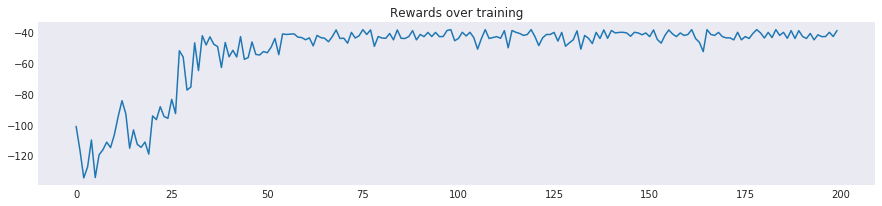

Initialized Delivery Environment with 20 random stops
Target metric for optimization is distance
else distance


episod: 0
episod: 100



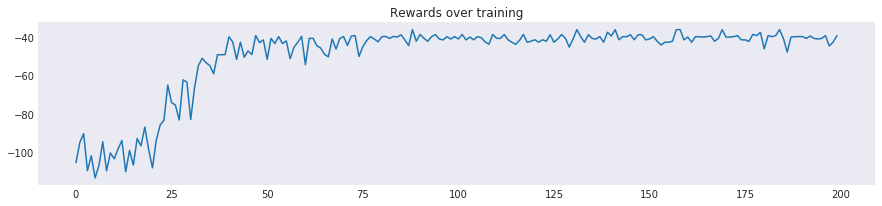

done


In [36]:
n_points = 30
max_box = 10
# points of interest
pois = np.random.rand(n_points, 2) * max_box
n_stops = 20
nSAMPLEs = 2

# enable database 
st_table = "TSP_20"
db = Storage(st_table)

for i in range(nSAMPLEs):
    task_indices = np.random.choice(n_points, n_stops, replace=False)
    reverse_task_ind = np.column_stack((np.arange(n_stops), task_indices))
    task_locations = pois[task_indices, :]
    # no does_task_exist check
    env = DeliveryEnvironment(n_stops = n_stops, method = "distance", poi = task_locations)
    agent = QAgent(nA=env.action_space, nS=env.observation_space, alpha=0.8, gamma=0.8, eps_start=1, eps_decay=0.95, eps_min=0.01, sars='max')
    env, agent = run_n_episodes(env,agent,"training_50_stops1.gif", n_episodes=200)
    #env.render()
    route_indices = env.stops # need a getter?
    global_route_indices = reverse_task_ind[route_indices,1]
    # add to the database
    route_dict = {"input_graph": task_indices.tolist(), "route": global_route_indices.tolist()}
    #res = db.insert_route(route_dict)

    
print('done')

In [ ]:
# todo
# generate CSV
csv_path = "path" 
db.generate_csv_from_table(st_table, csv_path)
